In [2]:
# Imports
import torch
import jovian
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [48]:
# Hyperparameters
batch_size = 256
learning_rate = 1e-5

# Other constants
input_size = 28*28
num_classes = 26

In [37]:
#dataset = pd.read_csv('sign_mnist_train.csv')
#testdataset = pd.read_csv('sign_mnist_test.csv')
#num_rows = dataset.shape[0]

# obter os dados de treinamento
dataTrain = pd.read_csv('sign_mnist_train.csv')
# obter os rotulos dos dados de treinamento
yTrain = dataTrain['label'].values
# remover os rotulos dos dados de treinamento
dataTrain.drop('label', axis = 1, inplace = True)
#numero de linhas (n. exemplos)
num_rows = dataTrain.shape[0]

# obter os dados de teste
dataTest = pd.read_csv('sign_mnist_test.csv')
# obter os rotulos dos dados de teste
yTest = dataTest['label'].values
#remover os rotulos dos dados de teste
dataTest.drop('label', axis = 1, inplace = True)
# verificar os dados de teste para verificar os rotulos de classe e as colunas que representam os pixeis
dataTest.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [38]:
# converter os dados de treinamento para um array
xTrain = dataTrain.values

# converter os dados de teste para um array
xTest = dataTest.values

In [140]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K' , 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X','Y']
letters = dict(enumerate(string.ascii_uppercase))
print(letters)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Text(0.5, 0.98, 'Some images from train data set')

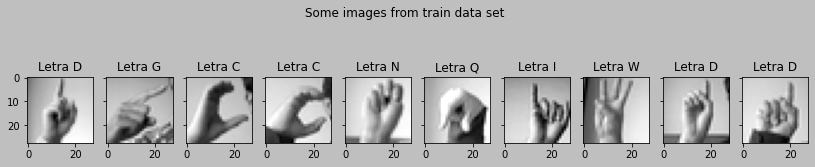

In [146]:
#Mostrar algumas imagem e respetivas letras
plt.style.use('grayscale')
fig, axs = plt.subplots(1, 10, figsize=(14, 3), sharey=True)
for i in range(10): 
    axs[i].imshow(xTrain[i].reshape(28,28),cmap='gray')
    axs[i].set_title(f'Letra {letters[yTrain[i].item()]}')
fig.suptitle('Some images from train data set')

In [41]:
inputs = torch.from_numpy(xTrain).float()
targets = torch.from_numpy(yTrain).long()
testinputs = torch.from_numpy(xTest).float()
testtargets = torch.from_numpy(yTest).long()

In [42]:
# Training validation & test dataset
dataset = TensorDataset(inputs, targets)
testdataset = TensorDataset(testinputs, testtargets)

# Let's use 15% of our training dataset to validate our model
val_percent = 0.15
val_size = int(num_rows * val_percent) #4118 para validar os dados
train_size = num_rows - val_size  #23337 para dados de traino
train_ds, val_ds = random_split(dataset, [train_size, val_size]) #train dados dataset e validação de dados do dataset

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(testdataset, batch_size*2)

In [50]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [51]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [52]:
evaluate(model, val_loader) #{'val_loss': 136.52188110351562, 'val_acc': 0.04259391129016876}

{'val_loss': 136.52188110351562, 'val_acc': 0.04259391129016876}

In [53]:
history = fit(50, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 469.3122, val_acc: 0.0452
Epoch [1], val_loss: 273.4714, val_acc: 0.0869
Epoch [2], val_loss: 102.9638, val_acc: 0.3713
Epoch [3], val_loss: 236.1637, val_acc: 0.0858
Epoch [4], val_loss: 103.2851, val_acc: 0.3393
Epoch [5], val_loss: 127.3551, val_acc: 0.4302
Epoch [6], val_loss: 84.3454, val_acc: 0.3230
Epoch [7], val_loss: 85.0916, val_acc: 0.4045
Epoch [8], val_loss: 109.0160, val_acc: 0.3747
Epoch [9], val_loss: 67.5084, val_acc: 0.5017
Epoch [10], val_loss: 36.3299, val_acc: 0.5003
Epoch [11], val_loss: 84.1897, val_acc: 0.3614
Epoch [12], val_loss: 33.8249, val_acc: 0.6507
Epoch [13], val_loss: 25.9733, val_acc: 0.5399
Epoch [14], val_loss: 40.5234, val_acc: 0.5594
Epoch [15], val_loss: 38.4222, val_acc: 0.5466
Epoch [16], val_loss: 70.5525, val_acc: 0.3857
Epoch [17], val_loss: 35.3166, val_acc: 0.5998
Epoch [18], val_loss: 24.4977, val_acc: 0.5896
Epoch [19], val_loss: 20.3268, val_acc: 0.5661
Epoch [20], val_loss: 44.3498, val_acc: 0.4704
Epoch [21], val_

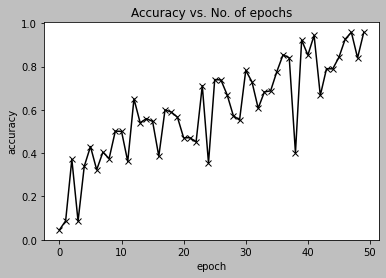

In [54]:
# Visualizing how our model performed after each epoch
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. Nº. of epochs');

In [77]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
print(result)
#{'val_loss': 12.54245376586914, 'val_acc': 0.690625011920929}

{'val_loss': 12.54245376586914, 'val_acc': 0.690625011920929}


In [69]:
model_2 = MnistModel()

In [70]:
# Evaluating the model prior to training
evaluate(model_2, val_loader)  #{'val_loss': 180.855712890625, 'val_acc': 0.04476404935121536}

{'val_loss': 180.855712890625, 'val_acc': 0.04476404935121536}

In [71]:
history_2 = fit(50, 1e-5, model_2, train_loader, val_loader)

Epoch [0], val_loss: 36.2866, val_acc: 0.0404
Epoch [1], val_loss: 29.0297, val_acc: 0.1098
Epoch [2], val_loss: 24.0678, val_acc: 0.1257
Epoch [3], val_loss: 20.6952, val_acc: 0.1692
Epoch [4], val_loss: 17.0718, val_acc: 0.1857
Epoch [5], val_loss: 15.3866, val_acc: 0.2666
Epoch [6], val_loss: 15.5454, val_acc: 0.2554
Epoch [7], val_loss: 12.0832, val_acc: 0.2671
Epoch [8], val_loss: 12.4440, val_acc: 0.3084
Epoch [9], val_loss: 12.6423, val_acc: 0.3001
Epoch [10], val_loss: 11.2410, val_acc: 0.3368
Epoch [11], val_loss: 8.1106, val_acc: 0.4179
Epoch [12], val_loss: 9.2763, val_acc: 0.3958
Epoch [13], val_loss: 9.6991, val_acc: 0.4071
Epoch [14], val_loss: 8.8747, val_acc: 0.4202
Epoch [15], val_loss: 8.0168, val_acc: 0.4299
Epoch [16], val_loss: 7.3015, val_acc: 0.4664
Epoch [17], val_loss: 6.6986, val_acc: 0.4450
Epoch [18], val_loss: 6.8084, val_acc: 0.4769
Epoch [19], val_loss: 7.3146, val_acc: 0.4729
Epoch [20], val_loss: 5.8752, val_acc: 0.5206
Epoch [21], val_loss: 4.6469, val

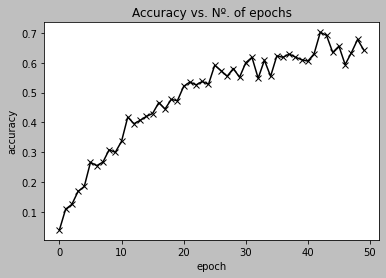

In [72]:
# Visualizing how our model performed after each epoch
accuracies = [r['val_acc'] for r in history_2]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. Nº. of epochs');

In [78]:
# Evaluate on test dataset
result_2 = evaluate(model_2, test_loader)
print(result_2)
#{'val_loss': 7.076575756072998, 'val_acc': 0.45781248807907104}

{'val_loss': 7.076575756072998, 'val_acc': 0.45781248807907104}


In [79]:
#Let’s try training it for 50 more epochs. (Dá um total de 100 epochs)
history_3 = fit(50, 1e-5, model_2, train_loader, val_loader)

Epoch [0], val_loss: 2.7797, val_acc: 0.6857
Epoch [1], val_loss: 3.5470, val_acc: 0.6025
Epoch [2], val_loss: 5.5188, val_acc: 0.5465
Epoch [3], val_loss: 1.9258, val_acc: 0.7084
Epoch [4], val_loss: 2.8325, val_acc: 0.6637
Epoch [5], val_loss: 1.9323, val_acc: 0.7461
Epoch [6], val_loss: 1.7395, val_acc: 0.7175
Epoch [7], val_loss: 3.4699, val_acc: 0.6259
Epoch [8], val_loss: 1.6775, val_acc: 0.7400
Epoch [9], val_loss: 1.4355, val_acc: 0.7631
Epoch [10], val_loss: 1.4215, val_acc: 0.7599
Epoch [11], val_loss: 1.9455, val_acc: 0.7073
Epoch [12], val_loss: 1.7797, val_acc: 0.7134
Epoch [13], val_loss: 1.2339, val_acc: 0.7825
Epoch [14], val_loss: 2.2938, val_acc: 0.7017
Epoch [15], val_loss: 3.3269, val_acc: 0.6577
Epoch [16], val_loss: 1.5498, val_acc: 0.7591
Epoch [17], val_loss: 1.1573, val_acc: 0.7944
Epoch [18], val_loss: 1.4768, val_acc: 0.7525
Epoch [19], val_loss: 1.3432, val_acc: 0.7708
Epoch [20], val_loss: 1.0207, val_acc: 0.8036
Epoch [21], val_loss: 3.1061, val_acc: 0.617

In [80]:
# Evaluate on test dataset
result_3 = evaluate(model_2, test_loader)
print(result_3)
#{'val_loss': 5.151068210601807, 'val_acc': 0.5307291746139526}

{'val_loss': 5.151068210601807, 'val_acc': 0.5307291746139526}


Using the Model to Predict Images:

In [119]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

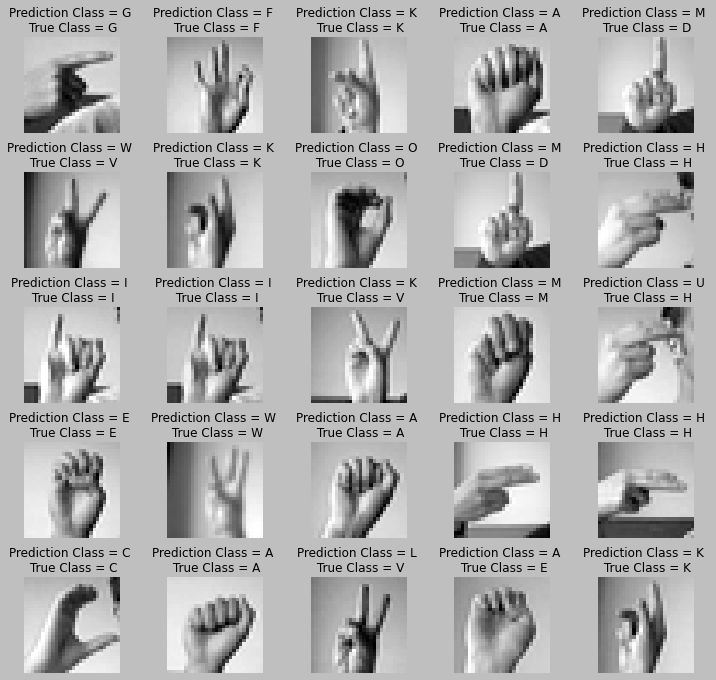

In [148]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12)) 
axes = axes.ravel() 
for i in np.arange (0, L * W):
    img, label = testdataset[i]
    axes[i].imshow(img.reshape(28,28)) 
    axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(letters[predict_image(img, model_2)], letters[label.item()])) 
    axes[i].axis('off') 
plt.subplots_adjust(wspace = 0.5)

In [149]:
# Here the model parameters are saved so that we dont have to train the model next time
torch.save(model_2.state_dict(), 'mnist-logistic.pth')

In [150]:
# Let's look at the model parameters
model_2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0288, -0.0061,  0.0233,  ..., -0.0215,  0.0261, -0.0036],
                      [ 0.0254,  0.0174,  0.0171,  ...,  0.0260, -0.0298,  0.0057],
                      [-0.0307,  0.0185,  0.0353,  ...,  0.0460,  0.0193, -0.0127],
                      ...,
                      [ 0.0184,  0.0368, -0.0280,  ..., -0.0156, -0.0001,  0.0341],
                      [ 0.0029,  0.0339, -0.0048,  ...,  0.0184,  0.0108,  0.0001],
                      [-0.0301, -0.0011, -0.0167,  ...,  0.0041,  0.0330, -0.0080]])),
             ('linear.bias',
              tensor([-2.7363e-02,  3.4343e-02,  2.4441e-02,  2.3302e-02,  5.1207e-03,
                       4.9389e-03,  2.5249e-02,  1.3157e-02,  1.5581e-03, -2.7936e-02,
                      -2.8555e-02, -2.7991e-02, -2.8795e-02,  1.8243e-02, -1.9146e-02,
                      -8.6432e-04, -6.9928e-03, -6.9907e-03, -3.3021e-03,  1.3675e-02,
                      -2.0234e-02, -2.1495e-02,  3.6052e-0